In [58]:
from gwtoolbox import tools_earth
from gwtoolbox.sources_kHz import DNS
from gwtoolbox.functions_earth import rho_sq_core
import matplotlib.pyplot as plt
import numpy as np
import os

In [46]:
# set cosmological parameters
H0 = 70
Om0 = 0.3
T0 = 2.725

In [9]:
# generate desired cosmology
cosmos = tools_earth.set_cosmology(None, H0, Om0, T0)

In [10]:
# R0, tau, m_mean, m_sclae, m_low, m_high, chi_sigma
# R0: merger rate [/yr/Gpc3] 
# tau: Delay time from formation to merger [Gyr]
# mass mean, standard deviation, low, high [solar masses]
# dispersion of effective spin
# be sure to keep these consistent with MOSFIT!
# find sauce to motivate the selected values
BNS_par = [300,3,1.4,0.5,1.1,2.5,0.1]

In [71]:
# summon the desired tool (LIGO)
Tools = tools_earth.Tools(detector_type='ligo', event_type='nsns', population=BNS_par, cosmos=cosmos)

In [66]:
Tools.detector.ante_pattern, Tools.noise

(<bound method LigoLike.ante_pattern of <gwtoolbox.detectors_earth.LigoLike object at 0x000002157DC332B0>>,
 [array([   5.    ,    5.0115,    5.0231, ..., 4977.    , 4988.5   ,
         5000.    ]),
  array([3.99880009e-40, 3.78769444e-40, 3.58799364e-40, ...,
         6.01426576e-46, 6.04176400e-46, 6.06981769e-46])])

In [15]:
# set generator parameters
time_obs = 60*24*100 # units of minutes of observation
rho_cri = 8 # signal-to-noise ratio cutoff

In [16]:
tot_num = Tools.total_number(time_obs, rho_cri)
print(tot_num)

6.589070552508693


In [17]:
# returns keys 'z','D','m1','m2','χ','dz','dm1','dm2','dχ','dD','dtb'
list_det = Tools.list_with_errors_df(time_obs, rho_cri, dtp=True)

In [19]:
Tools.list_with_iota(list_det)

,z,D,m1,m2,χ,dz,dm1,dm2,dχ,dD,dtb,inc
0,0.084105,382.983454,2.135318,1.994486,-0.028240,0.042053,0.126951,0.116534,0.000457,202.536785,0.090,1.036583
1,0.085896,391.618666,1.393244,2.401044,0.106019,0.042948,0.069662,0.120052,0.000386,207.314516,0.059,0.844997
2,0.035731,157.208362,1.555424,1.291508,-0.113265,0.017865,0.077771,0.064575,0.000126,80.669288,0.386,1.195912
3,0.019167,83.297909,1.752236,2.213494,0.010256,0.009583,0.087612,0.110675,0.001524,42.250312,0.806,1.200677
4,0.058846,263.276081,1.815847,1.454056,-0.066602,0.029423,0.090792,0.072703,0.000212,137.146235,0.160,0.643220


In [23]:
dns = DNS(cosmos)

In [91]:
def tel_fun(dns, z, m1, m2, iota, rho_cri, ant_fun, noise_tab):
    """
    The telescope function of Laser Interferometers and kHz sources.

    Parameters:
      z (float): The redshift of the GW source
      m1 (float): Red-shifted masses of the BHB
      m2 (float): Red-shifted masses of the BHB
      #chi (float): spin
      iota (float): inclination angle in radians
      rho_cri (float): The detection SNR threshold
      ant_fun (function): antenna pattern
      noise_tab (array of dtype float): noise function for detector

    Returns:
      (float): The probability of detection
    """
    # both masses should be intrinsic here.
    Mch = (m1*m2)**(5/6)/(m1+m2)**(1/5)
    
    random_angles_more=np.loadtxt("angles_more.dat")
    theta_array_more = random_angles_more[:,0]
    varphi_array_more = random_angles_more[:,1]
    iota_array_more = np.ones(len(random_angles_more[:,1]))*iota
    psi_array_more = random_angles_more[:,3]
    F = ant_fun(theta_array_more, varphi_array_more, psi_array_more)
    A_array = dns.mod_norm(Mch*(1+z), F, iota_array_more, z)
    
    f_up = dns.freq_limit(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    f2=dns.freq_limit_merger(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    f3=dns.freq_limit_ringdown(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    freq_sig=dns.freq_sigma(m1=m1*(1+z), m2=m2*(1+z), chi=0)
    f1=f_up
    rho_sq_core_value = rho_sq_core(noise_tab, dns.mod_shape, f_up=f_up)
    
    if len(A_array.shape)==2:
        rho_sq_array=4.*np.einsum('i...,i->i...',A_array**2,rho_sq_core_value)
        heav_array = np.heaviside(rho_sq_array-rho_cri**2,0)

        return np.mean(heav_array,axis=1)
    else: 
        rho_sq_array = np.array(4.*A_array**2*rho_sq_core_value)
        heav_array = np.heaviside(rho_sq_array-rho_cri**2,0)
        return np.mean(heav_array)

In [103]:
iota_array = np.linspace(0, np.pi/2, 100)
pd = [tel_fun(dns, 0.04, 1.4, 1.4, iota, rho_cri, Tools.detector.ante_pattern, Tools.noise) for iota in iota_array]

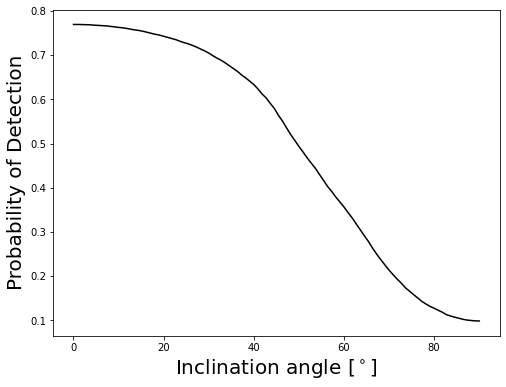

In [105]:
plt.figure(figsize=(8,6))
plt.plot(iota_array*180/np.pi, pd, '-k')
plt.ylabel('Probability of Detection', fontsize=20)
plt.xlabel('Inclination angle [$^\circ$]', fontsize=20)
plt.show()